# OPEN CITIES COMPETITION - DAC TEAM

# Chuẩn bị môi trường
Load libs và mount với google drive

In [0]:
# !pip install opencv-python==4.2.0.32

In [5]:
#Reload saved data and libs
import cv2
from google.colab.patches import cv2_imshow #Cannot use cv2.imshow
from google.colab import files, drive
from keras import Model
from keras.models import Sequential
# from keras.layers import Dense, Conv2D, Flatten, Dropout, Input,MaxPooling2D, concatenate, UpSampling2D, Lambda, Conv2DTranspose
from keras.layers import ( Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, 
                          Dropout, Flatten, Concatenate, concatenate, Reshape, Activation, Lambda, Conv2DTranspose, DepthwiseConv2D,
                          BatchNormalization, ReLU)
from keras.layers.core import Layer
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.models import load_model
from keras.regularizers import l2,l1
import numpy as np

drive.mount('/content/drive')
import glob, random
from sklearn.metrics import jaccard_score
from random import sample
import matplotlib.pyplot as plt
import tensorflow as tf
from random import choices, choice

# Kiểm tra GPU có chạy không
import tensorflow as tf
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Giải nén file trên google drive
# !pip install patool
# import patoolib
# patoolib.extract_archive("/content/drive/My Drive/open_cities_compet/data/test/test.rar", outdir="/content/drive/My Drive/open_cities_compet/data/test/full_test")

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4427949722406959361, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14193236190544736027
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 446943895715431025
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15956161332
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8713639248596084471
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [0]:
# import requests  
# file_url = "https://drivendata-public-assets-asia.s3-ap-southeast-1.amazonaws.com/test.tgz"
    
# r = requests.get(file_url, stream = True)  
  
# with open("/content/gdrive/My Drive/python.pdf", "wb") as file:  
#     for block in r.iter_content(chunk_size = 1024): 
#          if block:  
#              file.write(block)

In [0]:
# Mount 2 tài khoản drive vào colab
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
# !mkdir -p /content/drive2
# !google-drive-ocamlfuse /content/drive2

# Custom funcs
Hàm load data đã xử lý từ trước. Khi train model thì chạy vòng for để cắt dữ liệu thành từng chunk nhỏ --> train + evaluate (tách train/test thực hiện bằng tay)

Bước xử lý dữ liệu đã được thực hiện từ trước tại https://colab.research.google.com/drive/11YS5h_fMixm9q43oMKbnjzPCTYXhfKpp?authuser=1#scrollTo=Gs9Om7QPguIU.

Đầu vào của file này là các hình ảnh đã được cắt nhỏ 256x256x3.

*Xây dựng hàm training * --> gọi mô hình và training nó, gồm 3 bước:
* B1. Từ tập full dữ liệu, lấy ra một tập mẫu (subset) với kích thước được nhập trước
* B2. Từ tập subset, cắt nhỏ thành nhiều tập chunk
* B3. Tại mỗi thời điểm, chỉ load vào 1 chunk, chia tập này thành 2 phần là train set và validation set
* B4. train tập train với số epoch = 1, sau khi thu được kết quả thì kiểm nghiệm lại với tập validation
* B6. với mỗi global_epoch, lặp lại quá trình cho các chunk, số lượng global_epoch được nhập trước
* B7. kết thúc mỗi global_epoch, lưu lại mô hình theo đường dẫn nhập trước

In [0]:
# Loss function: jaccard distance and jaccard score metrix
def iou_coef(y_true, y_pred, smooth=1):
  y_pred = tf.math.round(y_pred)
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def iou_coef2(y_true, y_pred, smooth=1):
  # y_pred = tf.math.round(y_pred)
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

#define jaccard loss
def jaccard_distance(y_true, y_pred, smooth=100):
  y_pred = tf.math.round(y_pred)
  intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
  sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
  jac = (intersection + smooth) / (sum_ - intersection + smooth)
  return (1 - jac) * smooth

def focal_loss(alpha=0.25, gamma=2):
  def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
    weight_a = alpha * (1 - y_pred) ** gamma * targets
    weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
    
    return (tf.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b 

  def loss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    logits = tf.log(y_pred / (1 - y_pred))

    loss_ = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)

    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss_)

  return loss

def KerasFocalLoss(target, input):
    
    gamma = 2.
    input = tf.cast(input, tf.float32)
    
    max_val = K.clip(-input, 0, 1)
    loss = input - input * target + max_val + K.log(K.exp(-max_val) + K.exp(-input - max_val))
    invprobs = tf.log_sigmoid(-input * (target * 2.0 - 1.0))
    loss = K.exp(invprobs * gamma) * loss
    
    return K.mean(K.sum(loss, axis=1))

def dice_loss(y_true, y_pred):
  numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
  denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
  return 1 - (numerator + 100) / (denominator + 100)

def focal_dice_loss(y_true, y_pred):     
    return dice_loss(y_true, y_pred) + KerasFocalLoss(y_true, y_pred)

def dice_loss2(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))
    return tf.reshape(1 - numerator / denominator, (-1, 1, 1))

def dice_crossentropy_loss(y_true, y_pred):     
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def load_to_grayim(im_path):
  original_im = cv2.imread(im_path)
  return cv2.cvtColor(original_im, cv2.COLOR_BGR2GRAY)

def get_file_num(path):
  return len(glob.glob( path ) )

def get_subset(im_folder, subset_size = None):
  '''Từ một đường dẫn thư mục chứa ảnh --> lấy ra ngẫu nhiên sample một số ảnh'''
  im_list = glob.glob( im_folder ) 
  if subset_size is not None:
    if subset_size <=1:
      subset_num = subset_size*len(im_list)
    else:
      subset_num = subset_size
    im_list = sample( im_list, subset_size )
  im_list.sort()
  return im_list

def get_dense_subset(im_folder, subset_size = None, dense_min = 0):
  '''Lấy vào subset từ đường dẫn full, với điều kiện mask của nó phải có tỷ lệ công trình xây dựng lớn hơn tỷ lệ min dense_min
  * dense_min: 0-1 float- double, tỷ lệ đặc tối thiểu'''
  im_list = glob.glob( im_folder )
  selected_ims, black_list = [], []
  tried_times = 0
  # chừng nào chưa đủ tập và số lần thử chưa vượt quá 5 lần subset_size thì kiểm tra ảnh + add vào list
  while  len(selected_ims) <=subset_size and tried_times <= subset_size*5:
    try:
      # Lấy ngẫu nhiên 1 ảnh chưa lấy bao giờ
      im = []
      while len(im) == 0 :
        im = [i for i in [choice(im_list)] if i not in black_list ]
      im = im[0]
      black_list.append(im)
      mask = load_to_grayim( im.replace('images', 'masks').replace('.png', '_mask.png') )/255
      dense_ratio = np.sum(mask)/(256*256)
      if dense_ratio >= dense_min:
        selected_ims.append( im )
    except:
      pass
  return selected_ims

def load_train_data( im_list, chunk = (100, 1), eval = 0 ):
  '''Load dữ liệu từ một đường dẫn là folder chứa ảnh, convert thành dạng ma trận và trả về 2 array: 1 của ảnh, 1 của mask
    Tên mask phải bằng tên ảnh + thay thế images bằng masks + kết thúc bằng _mask.pnj
    # Lưu ý pick vị trí chunk là cố định
    * im_list: list, danh sách đường dẫn đến các file
    * chunk: tuple (chunk_size, chunk_position) or None, nếu là None thì load toàn bộ dữ liệu vào, vị trí chunk muốn lấy ra, ví dụ toàn dữ liệu có 10 chunk, mỗi chunk gồm 100 ảnh --> muốn lấy ra chunk nào
    * eval: 0-1, tỷ lệ cắt ra thành evaluate set, nếu = 0 --> không có evaluate set, nếu chạy từ 0-1 --> trả về IM_Train, MSK_Train, IM_EVAL, MSK_EVAL 
    '''
  if chunk is None:
    chunk_size, chunk_pos = len(im_list), 0
  else:
    ( chunk_size, chunk_pos ) = chunk 

  # với từng chunk ảnh, load dữ liệu vào 
  im_num = len(im_list) ## Số lượng ảnh
  chunk_num = round( im_num/chunk_size + 0.5 ) ## Số lượng chunk (làm tròn lên)

  # lấy danh sách ảnh cần lấy ra
  im_sta_pos = chunk_size*chunk_pos## Vị trí bắt đầu
  im_end_pos = min( chunk_size*(chunk_pos +1), im_num) ## vị trí kết thúc
  im_eval_pos = int( im_sta_pos + (1-eval)*(im_end_pos - im_sta_pos) )
  real_chunk_size = im_end_pos - im_sta_pos +1 ## Số lượng ảnh thực tế có của chunk này

  im_load_list = im_list[im_sta_pos:im_end_pos]

  X_train, y_train, X_eval, y_eval = [], [], [], []
  for i in range( real_chunk_size ):
    try:
      pos = i+ im_sta_pos -1
      im = im_list[pos]
      im_mask = im.replace('images', 'masks').replace('.png', '_mask.png')
      x_add = cv2.imread(im)
      y_add = load_to_grayim(im_mask)/255
      if pos < im_eval_pos:
        
        X_train.append( x_add  )
        y_train.append( y_add )
      else:
        X_eval.append( x_add )
        y_eval.append( y_add )
    except:
      pass
  
  X_train = np.array(X_train)
  X_eval = np.array(X_eval)

  y_train = np.array(y_train).reshape( len(y_train), 256, 256, 1 )
  y_eval = np.array(y_eval).reshape( len(y_eval), 256, 256, 1 )

  if eval != 0:
    return X_train, y_train, X_eval, y_eval
  else:
    return X_train, y_train

def evaluate_array_results(model, X, Y):
  '''Đánh giá kết quả mô hình, dựa vào dữ liệu đầu vào là dạng ma trận, X, y trong đó y đã sử lý về dạng 0-1
    * model: mô hình đã train, 
    * X: list chứa các array là dữ liệu của các ảnh
    * y: list chứa các array là các mask, trong đó mask đã xử lý chuyển về 0-1'''
  jaccards = []
  for i in range(len(X)):
    x = X[i]
    y_true = Y[i].reshape(256,256)
    y_pred = np.around( model.predict(x.reshape(1,256,256,3)))[0].reshape(256,256)
    jaccards.append( jaccard_score(y_true, y_pred, average= 'micro') )

    # Show image
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,5))
    ax1.imshow( x )
    ax2.imshow( y_true*255 )
    ax3.imshow( y_pred*255 )
  print('Average jaccards:', np.mean( jaccards ))
  return np.mean( jaccards )  

# đánh giá dựa trên dl load từ numpy
def evaluate_np_data(model, data_path, test_size, mask_path = None):
  '''Đánh giá mô hình dựa trên dl là dạng lưu numpy array, 
  * model: model đã train
  * data_path: đường dẫn chứa dữ liệu là array dạng (n, 256, 256, x) trong đó n là số ảnh, x là 3 với ảnh train, 1 với tập test
  * test_size: int, số lượng ảnh sẽ sử dụng để test'''
  if mask_path is None:
    mask_path = data_path.replace('train_data_', 'train_mask_')
  
  test_arr = np.load( data_path ) ['arr_0']
  pos_list = range(test_arr.shape[0])
  pos_choices = choices(pos_list, k = test_size)
  im_np_list = [ test_arr[i] for i in pos_choices ]

  mask_arr = np.load( mask_path ) ['arr_0']
  mask_np_list = [ mask_arr[i] for i in pos_choices ]

  return evaluate_array_results(model, X = im_np_list, Y= mask_np_list )

# Đánh giá dựa trên dl load numpy cho model có 2 channel
def evaluate_2channels_np_data(model, data_path, test_size):
  '''Đánh giá mô hình dựa trên dl là dạng lưu numpy array, 
  * model: model đã train
  * data_path: đường dẫn chứa dữ liệu là array dạng (n, 256, 256, x) trong đó n là số ảnh, x là 3 với ảnh train, 1 với tập test
  * test_size: int, số lượng ảnh sẽ sử dụng để test'''
  mask_path = data_path.replace('_train_data_', '_train_fbmask_')
  
  test_arr = np.load( data_path ) ['arr_0']
  pos_list = range(test_arr.shape[0])
  pos_choices = choices(pos_list, k = test_size)
  im_np_list = [ test_arr[i] for i in pos_choices ]

  mask_arr = np.load( mask_path ) ['arr_0']
  mask_np_list = [ mask_arr[i] for i in pos_choices ]

  # return evaluate_array_results(model, X = im_np_list, Y= mask_np_list )
  jaccards1, jaccards2 = [], []
  for i in range(len(im_np_list)):
    x = im_np_list[i]
    y_true = mask_np_list[i].reshape(256,256,2)
    y_pred = np.around( model.predict(x.reshape(1,256,256,3)))[0].reshape(256,256,2)
    jaccards1.append( jaccard_score(y_true[:,:,0], y_pred[:,:,0], average= 'micro') )
    jaccards2.append( jaccard_score(y_true[:,:,1], y_pred[:,:,1], average= 'micro') )

    # Show image
    fig, (ax1,ax2,ax3, ax4, ax5) = plt.subplots(1,5,figsize=(10,5))
    ax1.imshow( x )
    ax2.imshow( y_true[:,:,0]*255 )
    ax3.imshow( y_pred[:,:,0]*255 )
    ax4.imshow( y_true[:,:,1]*255 )
    ax5.imshow( y_pred[:,:,1]*255 )
  print('Average jaccards footprint:', np.mean( jaccards1 ))
  print('Average jaccards boundary:', np.mean( jaccards2 ))
  return np.mean( jaccards1 )  , np.mean( jaccards2 )    

def predict_and_save(model, ims, save_path):
  '''predict kết quả từ ảnh và lưu lại
  * model: model
  * ims: list, list đường dẫn ảnh test
  * save_path: str, thư mục sẽ lưu kết quả predict'''
  for im_dir in ims:
    im = cv2.imread(im_dir)
    y_pred = np.around( model.predict(im.reshape(1,256,256,3)))[0].reshape(256,256)*255
    pred_path = save_path + '/pred_'+im_dir.split('/')[-1]
    if cv2.imwrite(pred_path, y_pred):
      print('saved image: ',im_dir.split('/')[-1])
    else:
      print('cannot save: ',im_dir.split('/')[-1])
    # cv2_imshow( y_pred)

def evaluate_folder(model, im_list):
  '''Đánh giá mô hình, dữ liệu đầu vào là danh sách đường dẫn các ảnh x, y của tập dl test '''
  X, y_true = load_train_data(im_list, chunk = None, eval = 0)
  return evaluate_array_results(model, X, y_true)
    
def run_train(model, im_list, chunk_size = 100, eval = 0.1, epochs = 10, chunk_epochs = 1, batch_size = 1, save_path = None):
  '''Chạy thực hiện fit'''
  subset_size = len(im_list)
  for epoch in range(epochs):
    # Loop qua từng epoch --> mỗi epoch train hết toàn bộ subset
    for i in range( round( subset_size/chunk_size +0.49999999999999 ) ):
      # Loop qua từng chunk --> training cho từng chunk
      print('-'*10+' Training at global epoch: ',epoch +1,' / ', epochs, ', chunk: ', i+1, '/ ', round( subset_size/chunk_size +0.5 ), '-'*10)
      X_train, y_train, X_eval, y_eval = load_train_data(im_list, chunk= (chunk_size, i), eval = eval )
      history = model.fit(X_train, y_train, batch_size, epochs= chunk_epochs, validation_data = (X_eval, y_eval))
    # Kết thúc mỗi epoch thì lưu lại model 1 lần
    model.save(save_path)
  return history

def run_model(model, im_folder, chunk_size = 100, eval = 0.1, subset_size = 1000, epochs = 10, chunk_epochs =1, batch_size = 1, save_path = None, test_size = 0.1, dense_min = None):
  '''Chạy mô hình: lấy subset + tách train/test + train'''
  # B1. Cắt lấy subset
  print('-'*10+'['+'B1. Cắt lấy subset'+']'+'-'*10)
  if subset_size is None:
    subset_size = get_file_num(im_folder)
  if dense_min is None:
    im_list = get_subset(im_folder, subset_size)
  else:
    im_list = get_dense_subset(im_folder, subset_size, dense_min = dense_min)

  # B2. Tách train/test
  print('-'*10+'['+'B2. Tách train/test'+']'+'-'*10)
  test_num = int( test_size*subset_size) ## số lượng ảnh trong subset
  im_test = sample(im_list, test_num) ## list các ảnh nằm trong test set 
  im_train = [i for i in im_list if i not in im_test] ## list các ảnh nằm trong train set

  # B3. Training và lưu lại kết quả
  print('-'*10+'['+'B3. Training và lưu lại kết quả'+']'+'-'*10)
  run_train( model, im_list = im_train, chunk_size = chunk_size, eval = eval, epochs = epochs, chunk_epochs=chunk_epochs, batch_size =batch_size , save_path =save_path )

  # B4. Đánh giá kết quả
  print('-'*10+'['+'B4. Đánh giá kết quả'+']'+'-'*10)
  evaluate_folder( model, im_list = im_test )

# def predict_and_save(model, im_list):
#   '''B1. Predict cho tập test, là folder chứa các ảnh cần predict đã được cắt nhỏ 256x256, 
#     B2. nối các ảnh cùng tên lại thành file Zip 
#     B3. Lưu file trên vào  '''

class dac_model():
  def __init__(self, model):
    self.model = model 
  def run_model(self, im_folder, chunk_size = 100, eval = 0.1, subset_size = 1000, epochs = 10, chunk_epochs =1, batch_size = 1, save_path = None, test_size = 0.1, dense_min = None):
    '''Chạy mô hình: lấy subset + tách train/test + train
      * im_folder: str or list, đường dẫn đến danh sách ảnh, nếu là list thì là list đường dẫn ảnh cho sẵn'''
    # B1. Cắt lấy subset
    print('-'*10+'['+'B1. Cắt lấy subset'+']'+'-'*10)
    self.subset_size = subset_size
    if subset_size is None:
      self.subset_size = get_file_num(im_folder)
    if isinstance( im_folder, list ):
      self.im_list = im_folder
    else:
      if dense_min is None:
        self.im_list = get_subset(im_folder, self.subset_size)
      else:
        self.im_list = get_dense_subset(im_folder, self.subset_size, dense_min = dense_min)

    # B2. Tách train/test
    print('-'*10+'['+'B2. Tách train/test'+']'+'-'*10)
    test_num = int( test_size*self.subset_size) ## số lượng ảnh trong subset
    self.im_test = sample(self.im_list, test_num) ## list các ảnh nằm trong test set 
    self.im_train = [i for i in self.im_list if i not in self.im_test] ## list các ảnh nằm trong train set

    # B3. Training và lưu lại kết quả
    print('-'*10+'['+'B3. Training và lưu lại kết quả'+']'+'-'*10)
    self.history = run_train( self.model, im_list = self.im_train, chunk_size = chunk_size, eval = eval, epochs = epochs, chunk_epochs=chunk_epochs, batch_size =batch_size , save_path =save_path )

    # B4. Đánh giá kết quả
    print('-'*10+'['+'B4. Đánh giá kết quả'+']'+'-'*10)
    evaluate_folder( self.model, im_list = self.im_test )

def resizepredict_and_save(model, ims, save_path):
    '''predict kết quả từ ảnh và lưu lại
    * model: model
    * ims: list, list đường dẫn ảnh test
    * save_path: str, thư mục sẽ lưu kết quả predict'''
    for im_p in ims:
        im = cv2.resize( cv2.imread(im_p), (256,256) )
        pred_arr =  np.around( model.predict(im.reshape(1,256,256,3)))[0].reshape(256,256)*255
        pred_final = cv2.resize(pred_arr, (1024,1024))
        pred_path = save_path +'/'+ im_p.split('/')[-1] 
        if cv2.imwrite(pred_path, pred_final):
            print('saved image: ',im_p.split('/')[-1] )
        else:
            print('cannot save: ',im_p.split('/')[-1] )

# Build and compile model
Xây dựng và compile dạng mạng, lưu kết quả vào biến model

## UInceptionNet - 900k

In [0]:
def incep_block1(input_layer, block_name='inception1_1', block_unit_size = 16):
	'''Dựng inception block cơ bản'''
	with K.name_scope(block_name):
		con1_1 = Conv2D( block_unit_size , (1, 1), activation='relu', kernel_initializer='he_normal', padding='same') (input_layer)
		con1_2 = Dropout(0.4) (con1_1)
		con2_1 = Conv2D( block_unit_size*2, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same') (input_layer)
		con2_2 = Dropout(0.4) (con2_1)
		con2_3 = Conv2D(block_unit_size, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (con2_2)
		con3_1 = Conv2D(block_unit_size, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same') (input_layer)
		con3_2 = Dropout(0.4) (con3_1)
		con3_3 = Conv2D(block_unit_size, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same') (con3_2)
		poo1 = MaxPooling2D((2, 2),strides = 1, padding='same') (input_layer)
		con4_1 = Conv2D(block_unit_size, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same') (poo1)
		con4_2 = Dropout(0.2) (con4_1)

		output_layer = Concatenate(axis=-1)([con1_2,con2_3,con3_3,con4_2])
	return output_layer

def incep_block2(input_layer, block_name='inception2_1', block_unit_size = 16):
	'''Dựng inception block cơ bản'''
	with K.name_scope(block_name):
		con1_1 = Conv2D( block_unit_size*2 , (1, 1), activation='relu', kernel_initializer='he_normal', padding='same') (input_layer)
		con1_2 = Dropout(0.4) (con1_1)
		con3_1 = Conv2D(block_unit_size*2, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same') (input_layer)
		con3_2 = Dropout(0.4) (con3_1)
		con3_3 = Conv2D(block_unit_size, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same') (con3_2)
		con3_4 = Dropout(0.4) (con3_3)

		output_layer = Concatenate(axis=-1)([con1_2,con3_4])
	return output_layer

def incep_block3(input_layer, block_name='inception2_3', block_unit_size = 16):
	'''Dựng inception block cơ bản'''
	with K.name_scope(block_name):
		con1_1 = Conv2D( block_unit_size*2 , (2, 2), activation='relu', kernel_initializer='he_normal', padding='same') (input_layer)
		con1_2 = Dropout(0.4) (con1_1)
		con3_1 = MaxPooling2D((5, 5),strides = 1, padding='same') (input_layer)
		con3_2 = Conv2D(block_unit_size, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same') (con3_1)
		con3_3 = Dropout(0.4) (con3_2)

		output_layer = Concatenate(axis=-1)([con1_2,con3_3])
	return output_layer

#Unet, thay conv bằng 1 inception module
input_height = 256
input_width = 256
img_channels = 3

inputs = Input((input_height, input_width, img_channels))
#Chia tất cả giá trị cho 255 --> normalise về dạng 0-1
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D( 16 , (2, 2), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.4) (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = incep_block3(p1, 'inception_2', block_unit_size = 32)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = incep_block2(p2, 'inception_3', block_unit_size = 64)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D( 128 , (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(p3) #incep_block1(p3, 'inception_4', block_unit_size = 128)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

# c5 = incep_block1(p4, 'inception_5', block_unit_size = 256)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (p4)
u6 = concatenate([u6, c4])
c6 = Conv2D( 128 , (2, 2), activation='relu', kernel_initializer='he_normal', padding='same') (u6) #incep_block1(u6, 'inception_6', block_unit_size = 128)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = incep_block2(u7, 'inception_7', block_unit_size = 64)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = incep_block3(u8, 'inception_8', block_unit_size = 32)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D( 16 , (2, 2), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.4) (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss= dice_crossentropy_loss , metrics=['acc', iou_coef]) # 'binary_crossentropy'
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 208         lambda_1[0][0]                   
_________________________________________________________________________

## U-ResInception-Mobile-Net kết hợp
 Sử dụng kiến trúc tổng quan của Unet: đối xứng, gồm 2 pha: encode -> decode, có các residual block đối xứng nhau
* Tại mỗi pha, mỗi block encode hoặc decode gồm 2 phần: convolution block và sizing block
- Convolution block: là một inception block, cấu phần gồm convolution layers, depthwiseConv layers, BN, xây dựng theo kiến trúc của InceptionNet v3
- Sizing block: là down sample với pha encode hoặc upsample với pha decode
    * downsampling: sử dụng Efficient Grid Size reduction (InceptionV3), cấu phần gồm conv, DepthwiseConv, BN; có các kết nối residual connection giữa mỗi block
    * upsampling: tương tự downsample nhưng sử dụng TransposeConv để upsampling


In [0]:
def conv_block1(inputs, filters):
    '''* conv block
    * giữ nguyên size của ảnh
    * kết hợp giữa DwConv, Conv, BN, Relu'''
    x = DepthwiseConv2D( (3,3), padding = 'same', strides = 1, use_bias= True )(inputs)
    x= BatchNormalization()(x)
    x = Conv2D(filters, (1,1), kernel_initializer='he_normal', padding='same'  ) (x)
    x= BatchNormalization()(x)
    x = ReLU(60.) (x)

    y = Conv2D(filters, (1,1)) (inputs)
    y= BatchNormalization()(y)
    y = ReLU(60.) (y)

    z = Conv2D(filters, (1,1) , kernel_initializer='he_normal', padding='same' ) (inputs)
    z= BatchNormalization()(z)
    z= Conv2D(filters, (3,1), dilation_rate = 2, kernel_initializer='he_normal', padding='same' ) (z)
    z= BatchNormalization()(z)
    z= Conv2D(filters, (1,3),  dilation_rate = 2, kernel_initializer='he_normal', padding='same' ) (z)
    z= BatchNormalization()(z)
    z = ReLU(60.) (z)

    output_layer = Concatenate(axis=-1)([inputs, x,y,z])

    return output_layer

def conv_block2(inputs, filters):
    '''* conv block
    * giữ nguyên size của ảnh
    * kết hợp giữa DwConv, Conv, BN, Relu'''
    x = DepthwiseConv2D( (3,3), padding = 'same', strides = 1, use_bias= True )(inputs)
    x= BatchNormalization()(x)
    x = Conv2D(filters, (1,1), kernel_initializer='he_normal', padding='same'  ) (x)
    x= BatchNormalization()(x)
    x = ReLU(60.) (x)

    y = MaxPooling2D( (3,3), strides = 1, padding = 'same') (inputs)
    y= BatchNormalization()(y)
    y = Conv2D(filters, (1,1) , kernel_initializer='he_normal', padding='same' ) (y)
    y= BatchNormalization()(y)
    y = ReLU(60.) (y)

    z = Conv2D(filters, (1,1) , kernel_initializer='he_normal', padding='same' ) (inputs)
    z= BatchNormalization()(z)
    z= Conv2D(filters, (5,1), dilation_rate = 2, kernel_initializer='he_normal', padding='same' ) (z)
    z= BatchNormalization()(z)
    z= Conv2D(filters, (1,5),  dilation_rate = 2, kernel_initializer='he_normal', padding='same' ) (z)
    z= BatchNormalization()(z)
    z = ReLU(60.) (z)

    output_layer = Concatenate(axis=-1)([inputs, x,y,z])

    return output_layer

def conv_block3(inputs, filters):
    '''* conv block
    * giữ nguyên size của ảnh
    * kết hợp giữa DwConv, Conv, BN, Relu'''
    x = DepthwiseConv2D( (3,3), padding = 'same', strides = 1, use_bias= True )(inputs)
    x= BatchNormalization()(x)
    x = Conv2D(filters, (3,1), kernel_initializer='he_normal', padding='same'  ) (x)
    x= BatchNormalization()(x)
    x = Conv2D(filters, (1,3), kernel_initializer='he_normal', padding='same'  ) (x)
    x= BatchNormalization()(x)
    x = ReLU(60.) (x)

    y = MaxPooling2D( (3,3), strides = 1, padding = 'same') (inputs)
    y= BatchNormalization()(y)
    y = Conv2D(filters, (1,1) , kernel_initializer='he_normal', padding='same' ) (y)
    y= BatchNormalization()(y)
    y = ReLU(60.) (y)

    output_layer = Concatenate(axis=-1)([inputs, x,y])

    return output_layer

def downsample_block1(inputs, filters):
    x =  Conv2D(filters, (1,1) , kernel_initializer='he_normal', padding='same' ) (inputs)
    x= BatchNormalization()(x)
    x =  Conv2D(filters, (3,3) , kernel_initializer='he_normal', padding='same' ) (x)
    x= BatchNormalization()(x)
    x =  Conv2D(filters, (3,3) , strides = 2, kernel_initializer='he_normal', padding='same' ) (x)
    x= BatchNormalization()(x)

    y =  Conv2D(filters, (1,1) , kernel_initializer='he_normal', padding='same' ) (inputs)
    y= BatchNormalization()(y)
    y =  Conv2D(filters, (3,3) , strides = 2, kernel_initializer='he_normal', padding='same' ) (y)
    y= BatchNormalization()(y)

    z =  MaxPooling2D( (2,2) ) (inputs)
    z = BatchNormalization()(z)

    output_layer = Concatenate(axis=-1)([x,y,z])

    return output_layer

input_height = 256
input_width = 256
img_channels = 3

inputs = Input((input_height, input_width, img_channels))
#Chia tất cả giá trị cho 255 --> normalise về dạng 0-1
s = Lambda(lambda x: x / 255) (inputs)

c1 = conv_block1 ( s, filters = 16 ) # f=256
d1 = downsample_block1(c1, filters = 16) # f= 128

c2 = conv_block1( d1, filters = 32)
d2 = downsample_block1(c2, filters = 32) # f= 64

c3 = conv_block2( d2, filters = 64)
d3 = downsample_block1(c3, filters = 64) # f=32

c4 = conv_block2( d3, filters = 128 )
d4 = downsample_block1(c4, filters = 128) # f= 16

c5 = conv_block3(d4, filters = 256) 

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5) # f = 32
m6 = concatenate([u6, c4]) 
c6 = conv_block2( m6, filters = 128 )

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6) # f = 64
m7 = concatenate([u7, c3])
c7 = conv_block2( m7, filters = 64)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7) # f= 128
m8 = concatenate([u8, c2])
c8 = conv_block1(m8, filters = 32)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8) # f = 256
m9 = concatenate([u9, c1], axis=3)
c9 = conv_block1(m9, filters = 16)

outputs = Conv2D(2, (1, 1), activation='sigmoid') (c9) #Nếu chạy cho 1 channel thì là: Conv2D(1, (1, 1), activation='sigmoid') (c9)
# outputs = BatchNormalization()(outputs)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile( optimizer='adam', loss= dice_crossentropy_loss , metrics=['acc', iou_coef, iou_coef2]) # 'binary_crossentropy'
model.summary()








Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 256, 256, 16) 64          lambda_2[0][0]                   
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 256, 256, 16) 64          conv2d_18[0][0]                  
_____________________________________________________________________________________

### Turning ver 20191203 
'''Chỉnh sửa loss thành focal loss kết hợp dice loss, 
   thêm regulizer và dropout layer
   Giảm max của relu xuống 24'''

In [31]:
'''Chỉnh sửa loss thành focal loss kết hợp dice loss, 
   thêm regulizer và dropout layer
   Giảm max của relu xuống 24'''

def conv_block1(inputs, filters):
    '''* conv block
    * giữ nguyên size của ảnh
    * kết hợp giữa DwConv, Conv, BN, Relu'''
    x = DepthwiseConv2D( (3,3), padding = 'same', strides = 1, use_bias= True, depthwise_regularizer = l2(0.005) )(inputs)
    x = Dropout(0.25) (x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, (1,1), kernel_initializer='he_normal', padding='same' , kernel_regularizer = l2(0.005) ) (x)
    x = Dropout(0.35) (x)
    x = BatchNormalization()(x)
    x = ReLU(24.) (x)

    y = Conv2D(filters, (1,1)) (inputs)
    y = Dropout(0.25) (y)
    y= BatchNormalization()(y)
    y = ReLU(24.) (y)

    z = Conv2D(filters, (1,1) , kernel_initializer='he_normal', padding='same' , kernel_regularizer = l2(0.005) ) (inputs)
    z = Dropout(0.25) (z)
    z= BatchNormalization()(z)
    z= Conv2D(filters, (3,1), dilation_rate = 4, kernel_initializer='he_normal', padding='same', kernel_regularizer = l2(0.005) ) (z)
    z = Dropout(0.35) (z)
    z= BatchNormalization()(z)
    z= Conv2D(filters, (1,3),  dilation_rate = 4, kernel_initializer='he_normal', padding='same', kernel_regularizer = l2(0.005) ) (z)
    z = Dropout(0.35) (z)
    z= BatchNormalization()(z)
    z = ReLU(24.) (z)

    output_layer = Concatenate(axis=-1)([inputs, x,y,z])

    return output_layer

def conv_block2(inputs, filters):
    '''* conv block
    * giữ nguyên size của ảnh
    * kết hợp giữa DwConv, Conv, BN, Relu'''
    x = DepthwiseConv2D( (3,3), padding = 'same', strides = 1, use_bias= True , depthwise_regularizer = l2(0.005))(inputs)
    x = Dropout(0.25) (x)
    x= BatchNormalization()(x)
    x = Conv2D(filters, (1,1), kernel_initializer='he_normal', padding='same' , kernel_regularizer = l2(0.005) ) (x)
    x = Dropout(0.25) (x)
    x= BatchNormalization()(x)
    x = ReLU(24.) (x)

    y = MaxPooling2D( (3,3), strides = 1, padding = 'same') (inputs)
    y= BatchNormalization()(y)
    y = Conv2D(filters, (1,1) , kernel_initializer='he_normal', padding='same', kernel_regularizer = l2(0.005) ) (y)
    y = Dropout(0.25) (y)
    y= BatchNormalization()(y)
    y = ReLU(24.) (y)

    z = Conv2D(filters, (1,1) , kernel_initializer='he_normal', padding='same', kernel_regularizer = l2(0.005) ) (inputs)
    z = Dropout(0.25) (z)
    z= BatchNormalization()(z)
    z= Conv2D(filters, (5,1), dilation_rate = 4, kernel_initializer='he_normal', padding='same', kernel_regularizer = l2(0.005) ) (z)
    z = Dropout(0.35) (z)
    z= BatchNormalization()(z)
    z= Conv2D(filters, (1,5),  dilation_rate = 4, kernel_initializer='he_normal', padding='same', kernel_regularizer = l2(0.005) ) (z)
    z = Dropout(0.35) (z)
    z= BatchNormalization()(z)
    z = ReLU(24.) (z)

    output_layer = Concatenate(axis=-1)([inputs, x,y,z])

    return output_layer

def conv_block3(inputs, filters):
    '''* conv block
    * giữ nguyên size của ảnh
    * kết hợp giữa DwConv, Conv, BN, Relu'''
    x = DepthwiseConv2D( (3,3), padding = 'same', strides = 1, use_bias= True, depthwise_regularizer = l2(0.005) )(inputs)
    x = Dropout(0.25) (x)
    x= BatchNormalization()(x)
    x = Conv2D(filters, (3,1), kernel_initializer='he_normal', padding='same' , kernel_regularizer = l2(0.005) ) (x)
    x = Dropout(0.25) (x)
    x= BatchNormalization()(x)
    x = Conv2D(filters, (1,3), kernel_initializer='he_normal', padding='same' , kernel_regularizer = l2(0.005) ) (x)
    x = Dropout(0.25) (x)
    x= BatchNormalization()(x)
    x = ReLU(24.) (x)

    y = MaxPooling2D( (3,3), strides = 1, padding = 'same') (inputs)
    y= BatchNormalization()(y)
    y = Conv2D(filters, (1,1) , kernel_initializer='he_normal', padding='same', kernel_regularizer = l2(0.005) ) (y)
    y = Dropout(0.25) (y)
    y= BatchNormalization()(y)
    y = ReLU(24.) (y)

    output_layer = Concatenate(axis=-1)([inputs, x,y])

    return output_layer

def downsample_block1(inputs, filters):
    x =  Conv2D(filters, (1,1) , kernel_initializer='he_normal', padding='same', kernel_regularizer = l2(0.005) ) (inputs)
    x = Dropout(0.25) (x)
    x= BatchNormalization()(x)
    x =  Conv2D(filters, (3,3) , kernel_initializer='he_normal', padding='same', kernel_regularizer = l2(0.005) ) (x)
    x = Dropout(0.25) (x)
    x= BatchNormalization()(x)
    x =  Conv2D(filters, (3,3) , strides = 2, kernel_initializer='he_normal', padding='same', kernel_regularizer = l2(0.005) ) (x)
    x = Dropout(0.25) (x)
    x= BatchNormalization()(x)

    y =  Conv2D(filters, (1,1) , kernel_initializer='he_normal', padding='same', kernel_regularizer = l2(0.005) ) (inputs)
    y = Dropout(0.25) (y)
    y= BatchNormalization()(y)
    y =  Conv2D(filters, (3,3) , strides = 2, kernel_initializer='he_normal', padding='same', kernel_regularizer = l2(0.005) ) (y)
    y = Dropout(0.25) (y)
    y= BatchNormalization()(y)

    z =  MaxPooling2D( (2,2) ) (inputs)
    z = BatchNormalization()(z)

    output_layer = Concatenate(axis=-1)([x,y,z])

    return output_layer

input_height = 256
input_width = 256
img_channels = 3

inputs = Input((input_height, input_width, img_channels))
#Chia tất cả giá trị cho 255 --> normalise về dạng 0-1
s = Lambda(lambda x: x / 255) (inputs)

c1 = conv_block1 ( s, filters = 16 ) # f=256
d1 = downsample_block1(c1, filters = 16) # f= 128

c2 = conv_block1( d1, filters = 32)
d2 = downsample_block1(c2, filters = 32) # f= 64

c3 = conv_block2( d2, filters = 64)
d3 = downsample_block1(c3, filters = 64) # f=32

c4 = conv_block2( d3, filters = 128 )
d4 = downsample_block1(c4, filters = 128) # f= 16

c5 = conv_block3(d4, filters = 256)
# c5 = conv_block3(c5, filters = 256)
# c5 = conv_block3(c5, filters = 256)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5) # f = 32
m6 = concatenate([u6, c4]) 
c6 = conv_block2( m6, filters = 128 )

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6) # f = 64
m7 = concatenate([u7, c3])
c7 = conv_block2( m7, filters = 64)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7) # f= 128
m8 = concatenate([u8, c2])
c8 = conv_block1(m8, filters = 32)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8) # f = 256
m9 = concatenate([u9, c1], axis=3)
c9 = conv_block1(m9, filters = 16)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9) #Nếu chạy cho 1 channel thì là: Conv2D(1, (1, 1), activation='sigmoid') (c9)
# outputs = BatchNormalization()(outputs)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile( optimizer='adam', loss= focal_dice_loss , metrics=['acc', iou_coef]) # 'binary_crossentropy'
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 256, 256, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_272 (Conv2D)             (None, 256, 256, 16) 64          lambda_7[0][0]                   
__________________________________________________________________________________________________
dropout_309 (Dropout)           (None, 256, 256, 16) 0           conv2d_272[0][0]                 
____________________________________________________________________________________________

# Train
Train với dữ liệu mới hoặc load lại mô hình cũ

## Load model có custom loss func, compile lại

In [0]:
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

def KerasFocalLoss(target, input):
    
    gamma = 2.
    input = tf.cast(input, tf.float32)
    
    max_val = K.clip(-input, 0, 1)
    loss = input - input * target + max_val + K.log(K.exp(-max_val) + K.exp(-input - max_val))
    invprobs = tf.log_sigmoid(-input * (target * 2.0 - 1.0))
    loss = K.exp(invprobs * gamma) * loss
    
    return K.mean(K.sum(loss, axis=1))

In [10]:
model_path = '/content/drive/My Drive/open_cities_compet/model/Unet_n_derivative/20200311_v3_U_inception_mobile_resNet_5mprams.h5'
model = load_model( model_path,compile= False )
model.compile(optimizer='adam', loss= dice_loss , metrics=['acc', iou_coef]) # 'binary_crossentropy'
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 256, 256, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_82 (Conv2D)              (None, 256, 256, 16) 64          lambda_3[0][0]                   
__________________________________________________________________________________________________
batch_normalization_85 (BatchNo (None, 256, 256, 16) 64          conv2d_82[0][0]                  
____________________________________________________________________________________________

In [0]:
# # INPUT PARAMETERS
# im_folder = 'drive/My Drive/open_cities_compet/data/train/images-256/*.png'
# all_im_num = len( glob.glob( im_folder ) )
# print('Số lượng ảnh có trong kho train là: ', all_im_num)
# # Số lượng ảnh muốn train
# # train_size = min( 1000 , all_im_num)
# save_path = 'drive/My Drive/open_cities_compet/model/Unet_n_derivative/20200229_unet_inception_4mprams_test.h5'
# run_train(model, im_folder, chunk_size= 100, eval= 0.2, subset_size= 5000, epochs= 10, batch_size=1)

In [0]:
# Load lại model và compile
model_path = '/content/drive/My Drive/open_cities_compet/model/Unet_n_derivative/20200229_unet_inception_4mprams_test.h5'
model = load_model( model_path )
model.summary()

In [0]:
# Load model có custom loss func, compile lại

model_path = 'drive/My Drive/open_cities_compet/model/Unet_n_derivative/20200304_unet_inception_900kprams_test.h5'
model = load_model( model_path,compile= False )
model.compile(optimizer='adam', loss= dice_crossentropy_loss , metrics=['acc', iou_coef]) # 'binary_crossentropy'
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, 256, 256, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_214 (Conv2D)             (None, 256, 256, 16) 208         lambda_12[0][0]                  
__________________________________________________________________

# Test
Sử dụng khi chỉ muốn test model mà không cần train lại

In [0]:
# Lấy ngẫu nhiên một số lượng ảnh trong kho --> test với mô hình model
## Đường dẫn thư mục chứa ảnh / và đổi tên đường dẫn thì được mask
im_folder = 'drive/My Drive/open_cities_compet/data/train/images-256-2/*.png' 
## số lượng ảnh đem đi test
subset_size = 50

all_im_num = len( glob.glob( im_folder ) )
print('Số lượng ảnh có trong kho train là: ', all_im_num)
im_list = get_subset(im_folder, subset_size)
evaluate_folder( model, im_list = im_list )

## Test dữ liệu load từ file lưu numpy

In [29]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 256, 256, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_147 (Conv2D)             (None, 256, 256, 16) 64          lambda_5[0][0]                   
__________________________________________________________________________________________________
dropout_167 (Dropout)           (None, 256, 256, 16) 0           conv2d_147[0][0]                 
____________________________________________________________________________________________

In [26]:
#Test sử dụng data numpy
data_path = '/content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_data_4.npz'
test_size = 100
model_path = '/content/drive/My Drive/open_cities_compet/model/Unet_n_derivative/20200312_v3_U_inception_mobile_resNet_5mprams.h5'

# model = load_model( model_path,compile= False )

# def evaluate_np_data(model, data_path, test_size):
#   '''Đánh giá mô hình dựa trên dl là dạng lưu numpy array, 
#   * model: model đã train
#   * data_path: đường dẫn chứa dữ liệu là array dạng (n, 256, 256, x) trong đó n là số ảnh, x là 3 với ảnh train, 1 với tập test
#   * test_size: int, số lượng ảnh sẽ sử dụng để test'''
mask_path = data_path.replace('train_data_', 'train_mask_')

test_arr = np.load( data_path ) ['arr_0']
pos_list = range(test_arr.shape[0])
pos_choices = choices(pos_list, k = test_size)
im_np_list = [ test_arr[i] for i in pos_choices ]

mask_arr = np.load( mask_path ) ['arr_0']
mask_np_list = [ mask_arr[i] for i in pos_choices ]

X = im_np_list 
Y= mask_np_list

jaccards = []
for i in range(len(X)):
  x = X[i]
  y_true = Y[i].reshape(256,256)
  y_pred = np.around( model.predict(x.reshape(1,256,256,3)))[0].reshape(256,256)
  jaccards.append( jaccard_score(y_true, y_pred, average= 'micro') )

  # Show image
  fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,5))
  ax1.imshow( x )
  ax2.imshow( y_true*255 )
  ax3.imshow( y_pred*255 )



ValueError: ignored

In [28]:
np.around( model.predict(x.reshape(1,256,256,3)))[0].shape

(256, 256, 2)

## Test dữ liệu numpy 2 channel

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


Average jaccards footprint: 0.13513440888327913
Average jaccards boundary: 0.0


SyntaxError: ignored

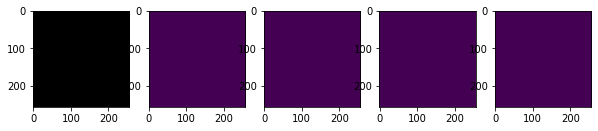

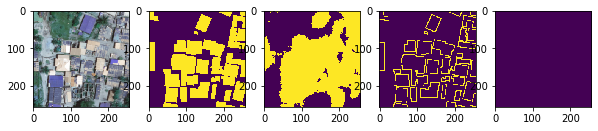

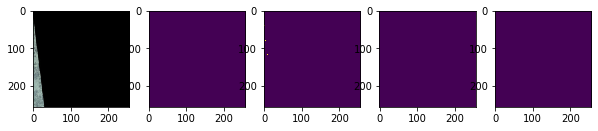

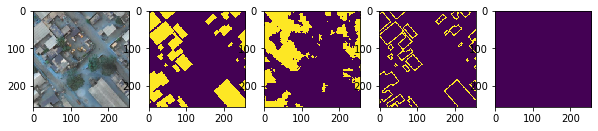

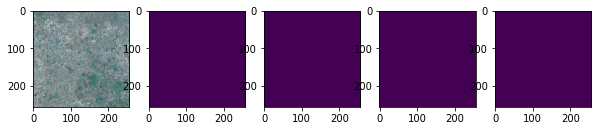

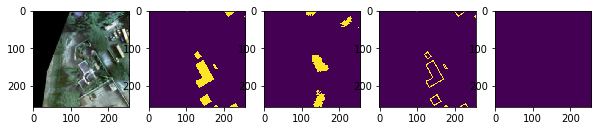

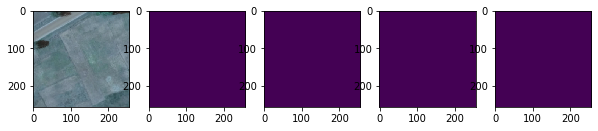

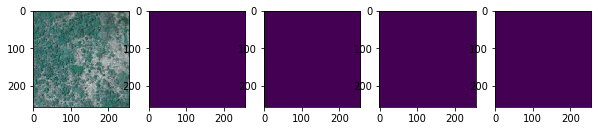

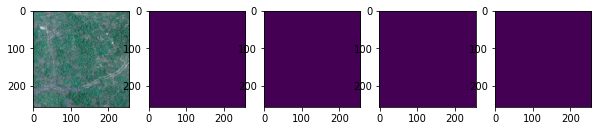

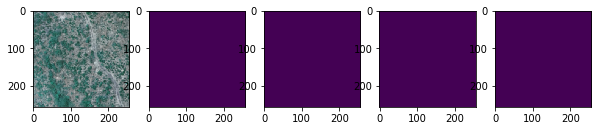

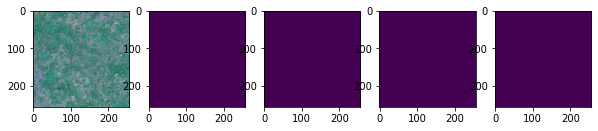

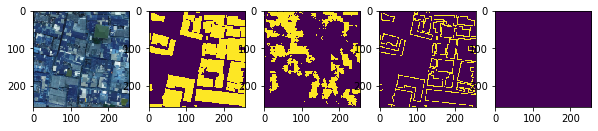

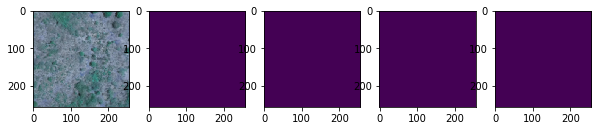

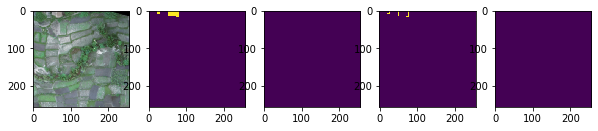

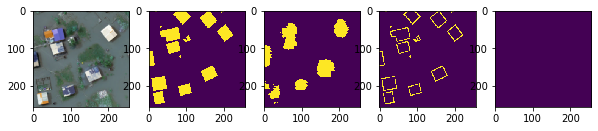

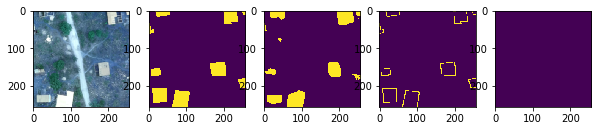

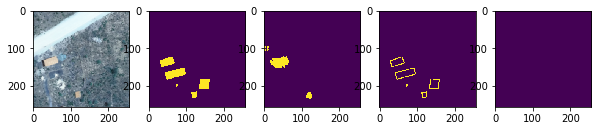

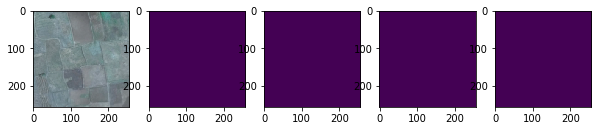

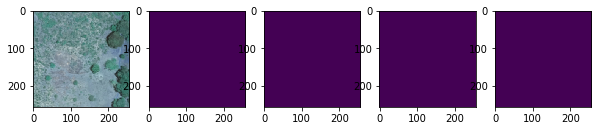

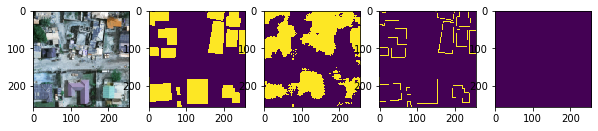

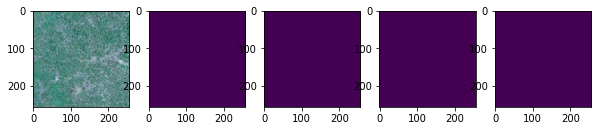

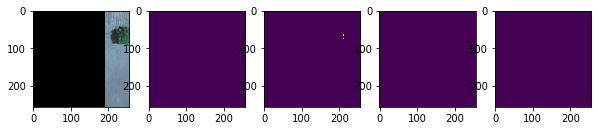

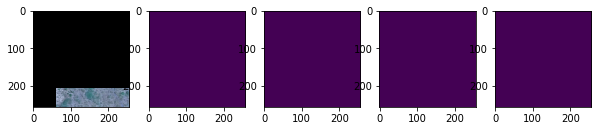

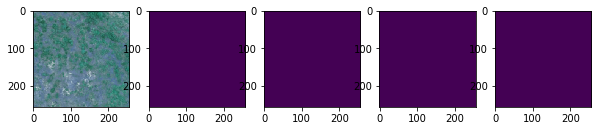

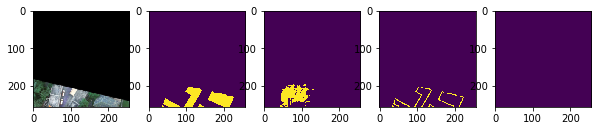

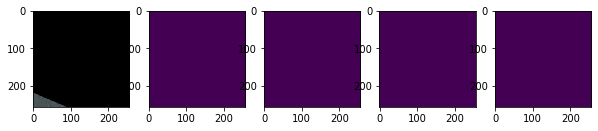

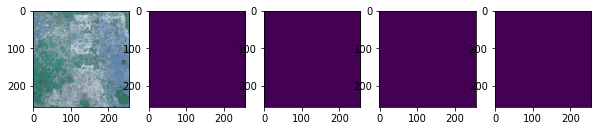

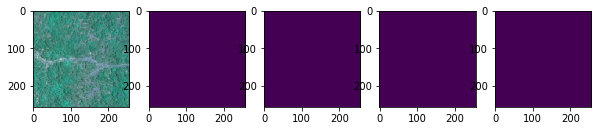

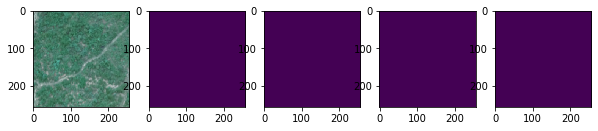

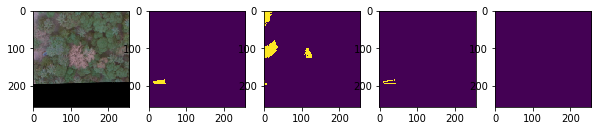

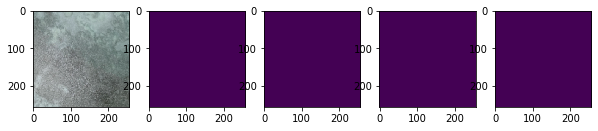

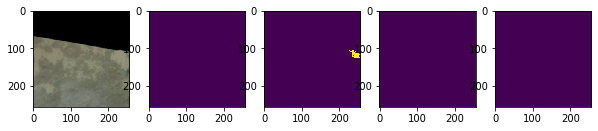

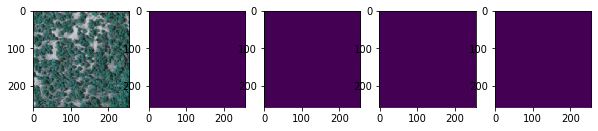

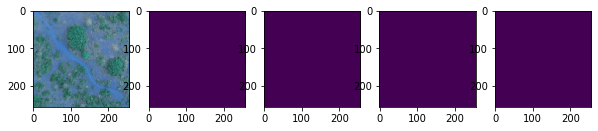

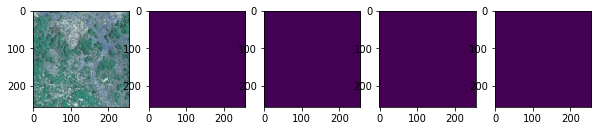

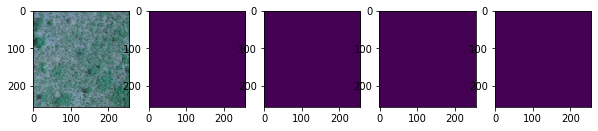

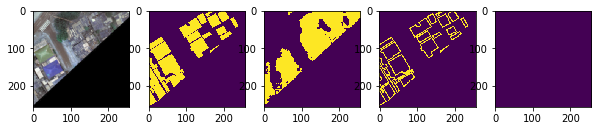

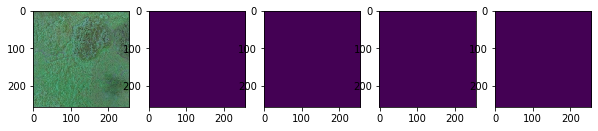

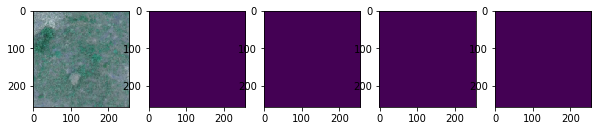

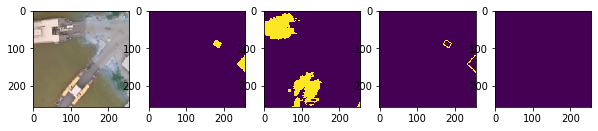

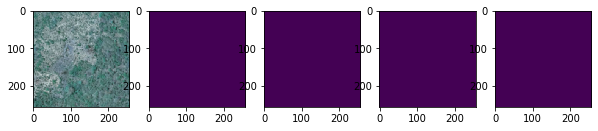

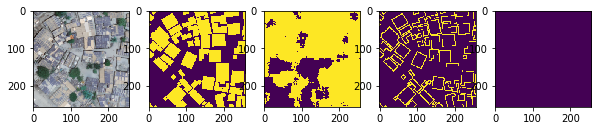

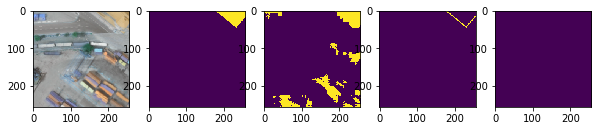

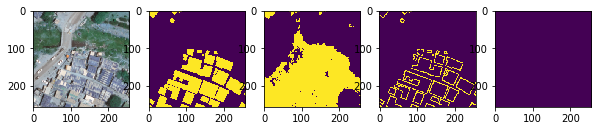

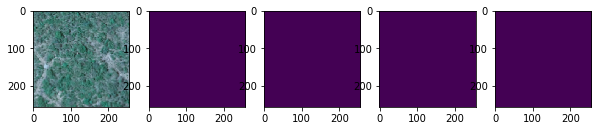

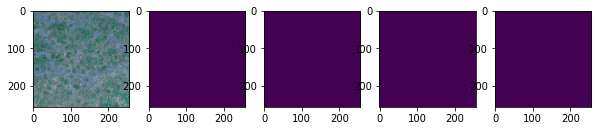

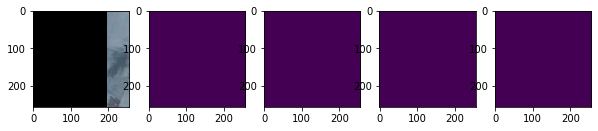

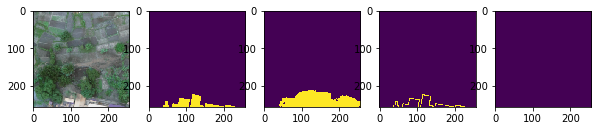

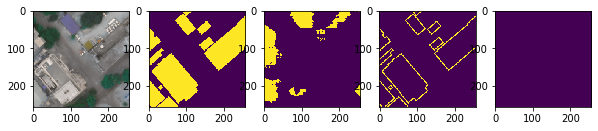

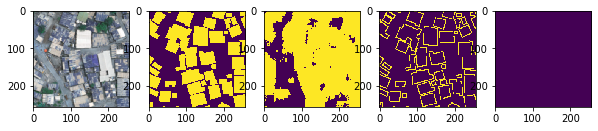

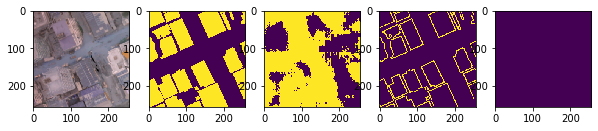

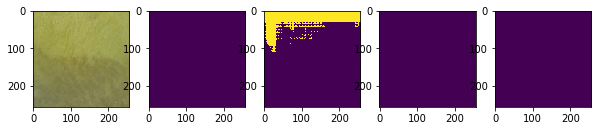

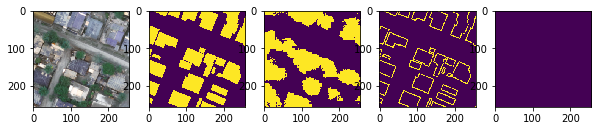

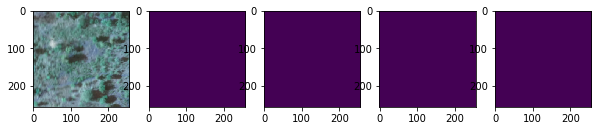

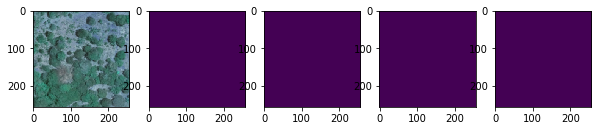

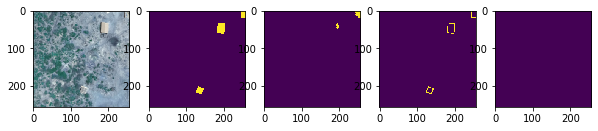

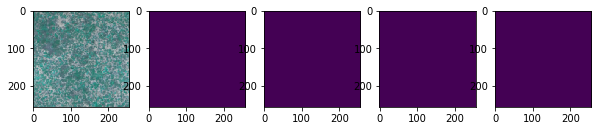

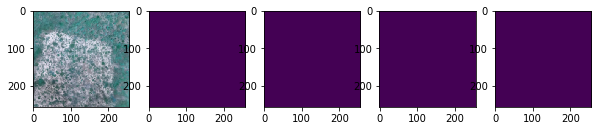

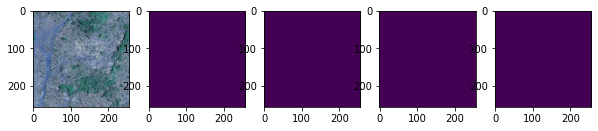

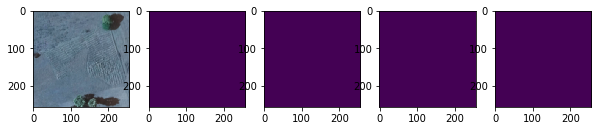

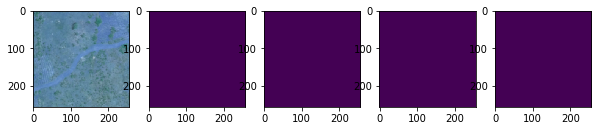

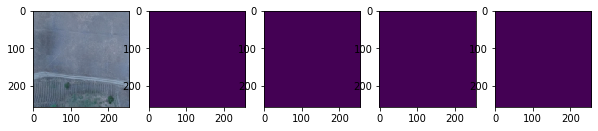

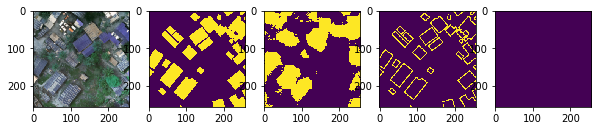

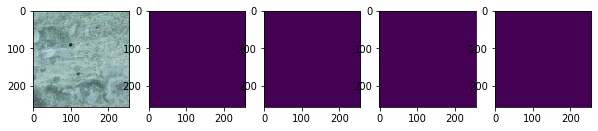

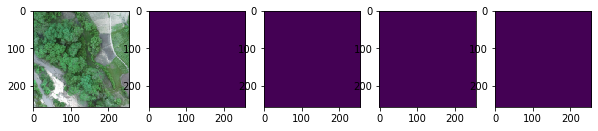

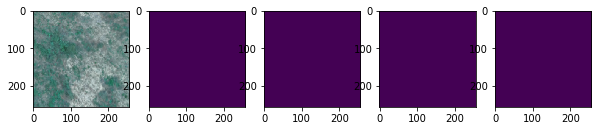

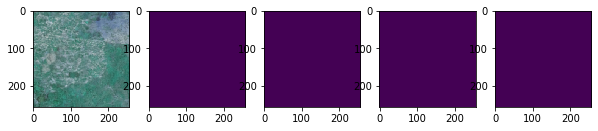

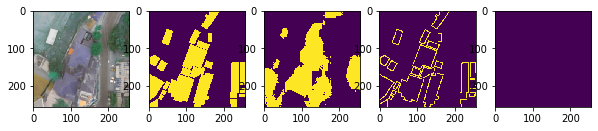

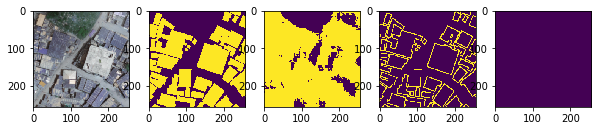

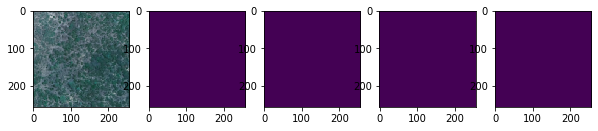

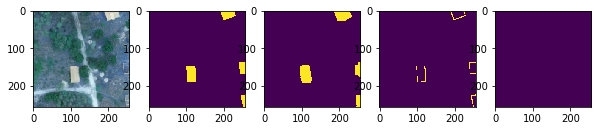

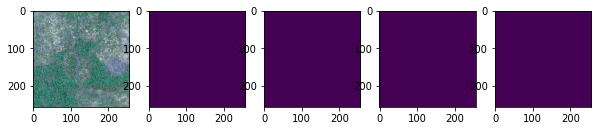

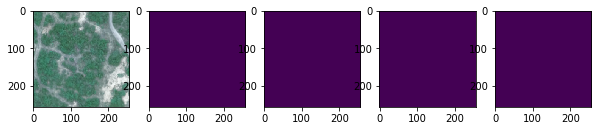

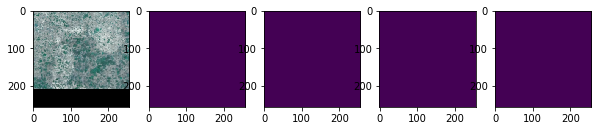

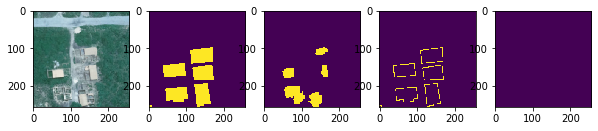

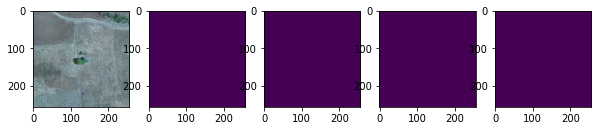

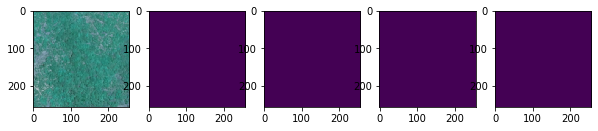

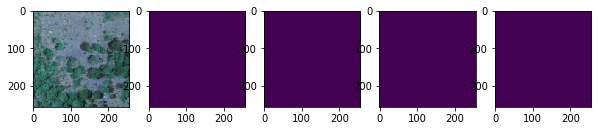

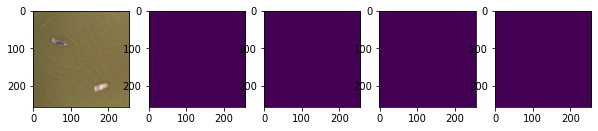

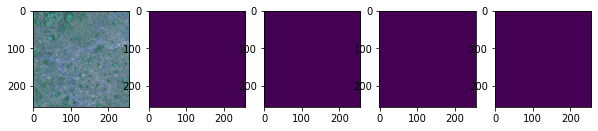

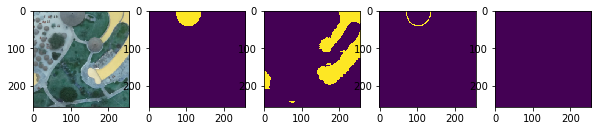

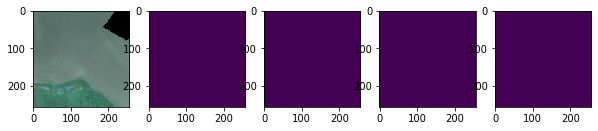

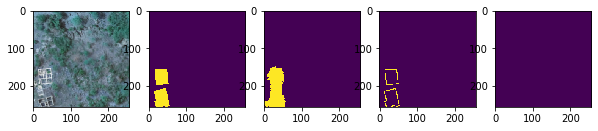

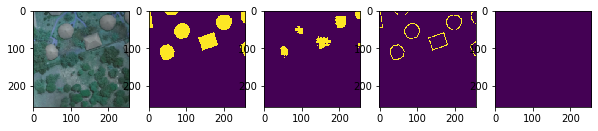

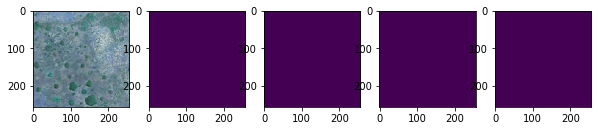

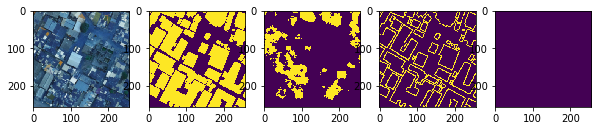

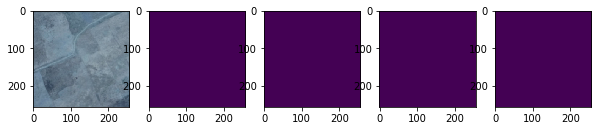

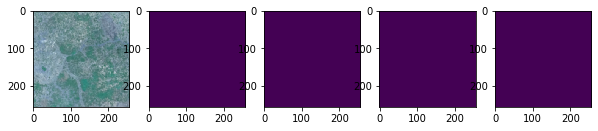

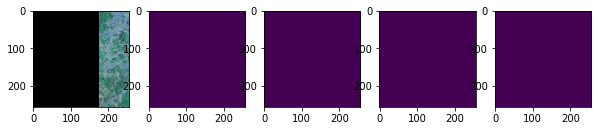

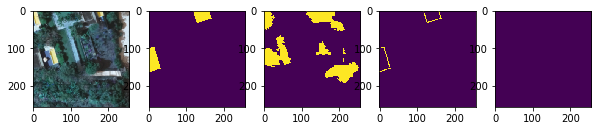

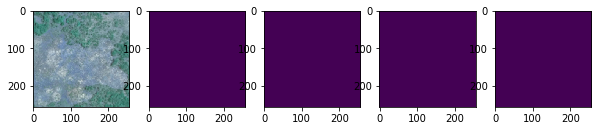

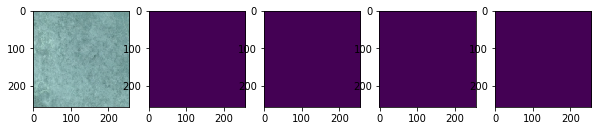

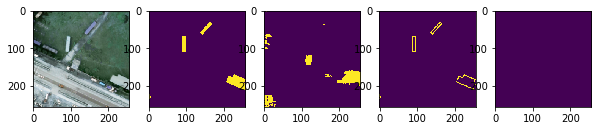

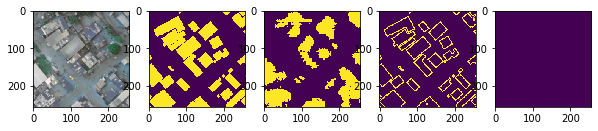

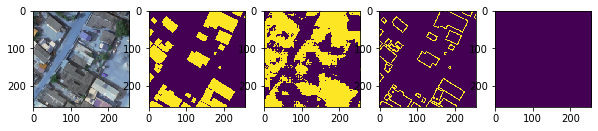

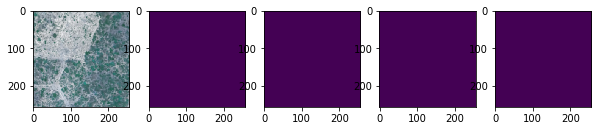

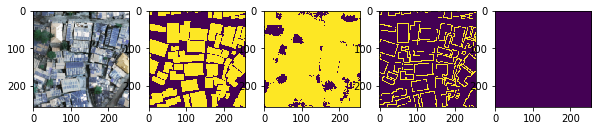

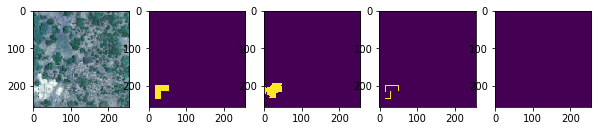

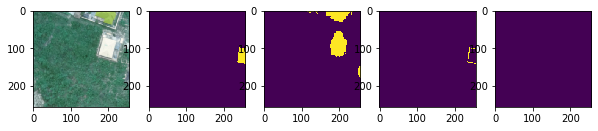

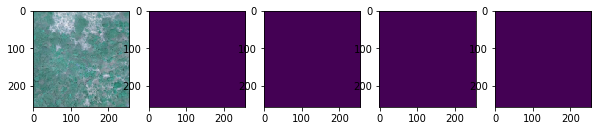

In [0]:
# #Test sử dụng data numpy
# data_path = '/content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_data_3.npz'
# test_size = 100


# '''Đánh giá mô hình dựa trên dl là dạng lưu numpy array, 
# * model: model đã train
# * data_path: đường dẫn chứa dữ liệu là array dạng (n, 256, 256, x) trong đó n là số ảnh, x là 3 với ảnh train, 1 với tập test
# * test_size: int, số lượng ảnh sẽ sử dụng để test'''
# mask_path = data_path.replace('_train_data_', '_train_fbmask_')

# test_arr = np.load( data_path ) ['arr_0']
# pos_list = range(test_arr.shape[0])
# pos_choices = choices(pos_list, k = test_size)
# im_np_list = [ test_arr[i] for i in pos_choices ]

# mask_arr = np.load( mask_path ) ['arr_0']
# mask_np_list = [ mask_arr[i] for i in pos_choices ]

# # return evaluate_array_results(model, X = im_np_list, Y= mask_np_list )
# jaccards1, jaccards2 = [], []
for i in range(len(im_np_list)):
  x = im_np_list[i]
  y_true = mask_np_list[i].reshape(256,256,2)
  y_pred = np.around( model.predict(x.reshape(1,256,256,3)))[0].reshape(256,256,2)
  jaccards1.append( jaccard_score(y_true[:,:,0], y_pred[:,:,0], average= 'micro') )
  jaccards2.append( jaccard_score(y_true[:,:,1], y_pred[:,:,1], average= 'micro') )

  # Show image
  fig, (ax1,ax2,ax3, ax4, ax5) = plt.subplots(1,5,figsize=(10,5))
  ax1.imshow( x )
  ax2.imshow( y_true[:,:,0]*255 )
  ax3.imshow( y_pred[:,:,0]*255 )
  ax4.imshow( y_true[:,:,1]*255 )
  ax5.imshow( y_pred[:,:,1]*255 )
print('Average jaccards footprint:', np.mean( jaccards1 ))
print('Average jaccards boundary:', np.mean( jaccards2 ))
return np.mean( jaccards1 )  , np.mean( jaccards2 )  

# Run model (Train + Test)
Sử dụng khi tạo model mới và train + test chung 1 session

In [0]:
# INPUT PARAMETERS
im_folder = 'drive/My Drive/open_cities_compet/data/train/images-256-2/*.png'
all_im_num = len( glob.glob( im_folder ) )
print('Số lượng ảnh có trong kho train là: ', all_im_num)
# Số lượng ảnh muốn train
# train_size = min( 1000 , all_im_num)
# im_list_storage = list( np.load('/content/drive/My Drive/open_cities_compet/model/prams/20200301_unet_inception_0.9mprams_test.npy.npz')['arr_0'] )
# try:
#   im_folder = cv_segmentation.im_list
# except:
#   pass

save_path = '/content/drive/My Drive/open_cities_compet/model/Unet_n_derivative/20200307_U_inception_mobile_resNet_5mprams.h5'
cv_segmentation = dac_model(model)
cv_segmentation.run_model( im_folder , chunk_size = all_im_num, eval = 0.25, 
                          subset_size = all_im_num, epochs = 1, chunk_epochs = 50, 
                          batch_size = 10, save_path = save_path, 
                          test_size = 0.25#                        , dense_min =0.3 
                          )
cv_segmentation.model.save( save_path ) 

In [0]:
# Load and train all imgs
# Load thẳng và train + lưu mỗi lần kết thúc 1 epoch
im_folder = 'drive/My Drive/open_cities_compet/data/train/images-256-2/*.png'
save_path = '/content/drive/My Drive/open_cities_compet/model/Unet_n_derivative/20200307_U_inception_mobile_resNet_5mprams.h5'

all_ims = glob.glob( im_folder )
all_im_num = len( all_ims )
print('Số lượng ảnh có trong kho train là: ', all_im_num)

X_train, y_train = [], []
for im in all_ims:
  try:
    im_mask = im.replace('images', 'masks').replace('.png', '_mask.png')
    x_add = cv2.imread(im)
    y_add = load_to_grayim(im_mask)/255
    
    X_train.append( x_add  )
    y_train.append( y_add )
  except: pass

X_train = np.array(X_train)
y_train = np.array(y_train).reshape( len(y_train), 256, 256, 1 )

for i in range(50):
  model.fit( X_train,y_train, epochs = 1, batch_size = 10, validation_split = 0.3 )
  cv_segmentation.model.save( save_path ) 


## Run dữ liệu load numpy

In [0]:
# Run bằng dữ liệu load từ numpy
# data_path = '/content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_data_3.npz'
save_path = '/content/drive/My Drive/open_cities_compet/model/Unet_n_derivative/20200312_v3_U_inception_mobile_resNet_5mprams.h5'

# mask_path = data_path.replace('_train_data_', '_train_mask_')
# X_train = np.load( data_path ) ['arr_0']
# y_train = np.load( mask_path ) ['arr_0']

for i in range(50):
  model.fit( X_train,y_train, epochs = 1, batch_size = 10, validation_split = 0.3 )
  model.save( save_path )

### Train nhiều tập

In [0]:
# Training nhiều tập dl
save_path = '/content/drive/My Drive/open_cities_compet/model/Unet_n_derivative/20200312_v1_U_inception_mobile_resNet_10mprams.h5'
data_paths = ['/content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_data_3.npz'
             ,'/content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_data_2.npz'
             ,'/content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_data_1.npz'
             ,'/content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_data_4.npz']
while 1==1:
  for data_path in data_paths:
    mask_path = data_path.replace('_train_data_', '_train_mask_')
    X_train = np.load( data_path ) ['arr_0']
    y_train = np.load( mask_path ) ['arr_0']
    for i in range(5):
      model.fit( X_train,y_train, epochs = 1, batch_size = 10, validation_split = 0.3 )
      model.save( save_path ) 

### Train đa tập - Dense data

In [0]:
# Training nhiều tập dl - dense
save_path = '/content/drive/My Drive/open_cities_compet/model/Unet_n_derivative/20200312_v1_U_inception_mobile_resNet_10mprams.h5'
data_paths = ['/content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_dense_0.2_data_1.npz'
             ,'/content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_dense_0.2_data_2.npz'
             ,'/content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_dense_0.2_data_3.npz'
             ]
while 1==1:
  for data_path in data_paths:
    mask_path = data_path.replace('_train_dense_0.2_data_', '_train_dense_mask_0.2')
    X_train = np.load( data_path ) ['arr_0']
    y_train = np.load( mask_path ) ['arr_0']
    for i in range(5):
      model.fit( X_train,y_train, epochs = 1, batch_size = 10, validation_split = 0.3 )
      model.save( save_path ) 

Train on 1455 samples, validate on 624 samples
Epoch 1/1
 420/1455 [=======>......................] - ETA: 1:08 - loss: 45.5275 - acc: 0.5907 - iou_coef: 2.8635e-04

## Run load numpy dl 2 channel

In [0]:
# Run bằng dữ liệu load từ numpy
data_path = '/content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_data_1.npz'
save_path = '/content/drive/My Drive/open_cities_compet/model/Unet_n_derivative/202003010_U_inception_mobile_resNet_2channel_5mprams.h5'

mask_path = data_path.replace('_train_data_', '_train_fbmask_')
X_train = np.load( data_path ) ['arr_0']
y_train = np.load( mask_path ) ['arr_0']

# Thay đổi class_weight để tăng mức ảnh hưởng của việc đoán được nhãn 1 gấp 100 lần nhãn 0
# class_weights = {0: 1., 1: 100.}
class_weights = np.zeros((4096, 2))
class_weights[:, 0] += .001
class_weights[:, 1] += 1

for i in range(50):
  history = model.fit( X_train,y_train, epochs = 1, batch_size = 10, validation_split = 0.3, class_weight= class_weights )
  model.save( save_path ) 



Train on 5730 samples, validate on 2456 samples
Epoch 1/1
5730/5730 [==============================] - 396s 69ms/step - loss: 1.0149 - acc: 0.8777 - iou_coef: 0.5240 - iou_coef2: 0.0811 - val_loss: 1.0586 - val_acc: 0.9408 - val_iou_coef: 0.3595 - val_iou_coef2: 0.2189
Train on 5730 samples, validate on 2456 samples
Epoch 1/1
5730/5730 [==============================] - 364s 64ms/step - loss: 0.9742 - acc: 0.7971 - iou_coef: 0.6150 - iou_coef2: 0.1212 - val_loss: 1.0553 - val_acc: 0.9329 - val_iou_coef: 0.3591 - val_iou_coef2: 0.2193
Train on 5730 samples, validate on 2456 samples
Epoch 1/1
5730/5730 [==============================] - 365s 64ms/step - loss: 0.9551 - acc: 0.7107 - iou_coef: 0.6442 - iou_coef2: 0.1593 - val_loss: 1.0127 - val_acc: 0.7359 - val_iou_coef: 0.3781 - val_iou_coef2: 0.2274
Train on 5730 samples, validate on 2456 samples
Epoch 1/1
1720/5730 [========>.....................] - ETA: 3:53 - loss: 0.9539 - acc: 0.7173 - iou_coef: 0.6786 - iou_coef2: 0.1674

KeyboardInterrupt: ignored

In [0]:
# Run bằng dữ liệu load từ numpy | dense data
data_path = '/content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_dense_0.2_data_1.npz'
save_path = '/content/drive/My Drive/open_cities_compet/model/Unet_n_derivative/202003010_U_inception_mobile_resNet_2channel_5mprams.h5'

mask_path = '/content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_dense_mask_0.21.npz'
X_train = np.load( data_path ) ['arr_0']
y_train = np.load( mask_path ) ['arr_0']

# Thay đổi class_weight để tăng mức ảnh hưởng của việc đoán được nhãn 1 gấp 100 lần nhãn 0
# class_weights = {0: 1., 1: 100.}
class_weights = np.zeros((4096, 2))
class_weights[:, 0] += .001
class_weights[:, 1] += 1

for i in range(50):
  history = model.fit( X_train,y_train, epochs = 1, batch_size = 10, validation_split = 0.3, class_weight= class_weights )
  model.save( save_path ) 

Train on 1606 samples, validate on 689 samples
Epoch 1/1
1606/1606 [==============================] - 104s 64ms/step - loss: 0.9056 - acc: 0.9826 - iou_coef: 0.4421 - iou_coef2: 0.3695 - val_loss: 0.9586 - val_acc: 0.9973 - val_iou_coef: 0.4124 - val_iou_coef2: 0.3562
Train on 1606 samples, validate on 689 samples
Epoch 1/1
1310/1606 [=======================>......] - ETA: 17s - loss: 0.8464 - acc: 0.9941 - iou_coef: 0.4686 - iou_coef2: 0.3962

In [0]:
for i in range(50):
  model.fit( X_train,y_train, epochs = 1, batch_size = 100, validation_split = 0.3 )
  model.save( save_path )

Train on 6396 samples, validate on 2742 samples
Epoch 1/1


In [0]:
# np.savez('/content/drive/My Drive/open_cities_compet/model/prams/20200301_unet_inception_0.9mprams_test.npy', np.array(im_list_storage))

In [0]:
# save_path = 'drive/My Drive/open_cities_compet/model/Unet_n_derivative/20200301_unet_inception_0.9mprams_test.h5'
# cv_segmentation.model.save( save_path ) 

In [0]:
# Move ảnh từ thư mục tránh đầy thư mục --> time out
import shutil
from random import choice
# Thư mục cần chuyển
from_path = 'drive/My Drive/open_cities_compet/data/train/images-256/*.png'

# Phần đã chuyển 
move_to_path = '/content/drive/My Drive/open_cities_compet/data/train/images-256-4/'

all_ims = glob.glob( from_path )
print(len(all_ims))
move_to_mask = move_to_path.replace('images','masks') # thư mục chứa mask
moved_list = glob.glob( move_to_path + '/*.pnj' ) # các file đã chuyển
for i in range(5000):
  im = choice(all_ims)
  if im not in moved_list:
    try:
      mask = im.replace('images', 'masks').replace('.png', '_mask.png')
      shutil.move( im, move_to_path )
      shutil.move( mask, move_to_mask )
    except: 
      pass
  moved_list = glob.glob(  move_to_path + '/*.pnj' )
print(len(moved_list))
print(len(glob.glob(from_path)))

12300


In [0]:
# Lưu lại mô hình
save_path = '/content/drive/My Drive/open_cities_compet/model/Unet_n_derivative/20200307_U_inception_mobile_resNet_5mprams.h5'
cv_segmentation.model.save( save_path ) 

In [0]:
# Tải mô hình xuống máy local
model_path = '/content/drive/My Drive/open_cities_compet/model/Unet_n_derivative/20200309_U_inception_mobile_resNet_5mprams.h5'
files.download( model_path )

# Predict and save results
Predict kết quả của test_set và lưu lại thành file .zip trong drive

In [0]:
ims = glob.glob('/content/drive/My Drive/open_cities_compet/data/test/full_test/test/*/*.tif')
saved_predict_path = '/content/drive/My Drive/open_cities_compet/data/predict/predict_model_unet_incep_900k'

# Load list ảnh trong thư mục test
resizepredict_and_save(model, ims, saved_predict_path)

saved image:  6a255c.tif


In [0]:
#compress to a file
!tar -czf /content/drive/My\ Drive/open_cities_compet/data/predict/predict_model_unet_incep_900k.tar '/content/drive/My Drive/open_cities_compet/data/predict/predict_model_unet_incep_900k/'

# Others

In [0]:
# Lưu ảnh về array --> kỳ vọng giảm thời gian load + convert sang array
# Load and train all imgs
# Load thẳng và train + lưu mỗi lần kết thúc 1 epoch
im_folder = 'drive/My Drive/open_cities_compet/data/train/images-256/*.png'

all_ims = glob.glob( im_folder )
all_im_num = len( all_ims )
print('Số lượng ảnh có trong kho train là: ', all_im_num)

X_train, y_train = [], []
for im in all_ims:
  try:
    im_mask = im.replace('images', 'masks').replace('.png', '_mask.png')
    x_add = cv2.imread(im)
    y_add = load_to_grayim(im_mask)/255
    
    X_train.append( x_add  )
    y_train.append( y_add )
    print('saved ', len(X_train) )
  except: 
    print('cannot convert:' , im.split('/')[-1] )
    raise

X_train = np.array(X_train)
y_train = np.array(y_train).reshape( len(y_train), 256, 256, 1 ).astype(int)

np.savez('/content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_data_1.npy', X_train)
np.savez('/content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_mask_1.npy', y_train)

Số lượng ảnh có trong kho train là:  8186


In [0]:
# Phán đoán đường bao và ranh giới nhà
mask_path =  '/content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_mask_3.npz'
mask_data = np.load(mask_path) ['arr_0'].astype(int)
np.savez(mask_path, mask_data)

In [0]:
mask_data = np.load(mask_path) ['arr_0'].astype(int)

In [0]:
im_mask = mask_data[8999].astype(int).reshape(256,256)
im_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])

In [0]:
# Find contours:
im, contours, hierarchy = cv2.findContours( im_uint, cv2.RETR_FLOODFILL , cv2.CHAIN_APPROX_NONE)

error: ignored

In [0]:
# gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply cv2.threshold() to get a binary image
(ret, thresh222) = cv2.threshold((im_mask*255).astype(np.uint8), 50, 255, cv2.THRESH_BINARY)

# Find contours:
contours, hierarchy = cv2.findContours(thresh222, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

In [0]:
cv2.drawContours( im_mask*255 , contours, -1, (0,255,0), 3) 

<UMat 0x7f6857b072d0>

In [0]:
!pip install solaris==0.2.0
# import solaris as sol

  Using cached https://files.pythonhosted.org/packages/12/df/28ddec28b677641738894a34a1491c79dc3a72eacdbceea7dc8cf7838ecd/solaris-0.2.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ac/a6/1a39a1ede71210e3ddaf623982b06ecfc5c5c03741ae659073159184cd3e/affine-2.3.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/47/55/fd9170ba08a1a64a18a7f8a18f088037316f2a41be04d2fe6ece5a653e8f/tqdm-4.43.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/77/63/a9fa76de8dffe7455304c4ed635be4aa9c0bacef6e0633d87d5f54530c5c/tensorflow-1.13.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/7b/d2/a2dbf83d4553ca6b3701d91d75e42fe50aea97acdc00652dca515749fb5d/opencv_python-4.1.0.25-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/56/6f/f1e91001d5ad9fa9bed65875152f5a1c7955c5763168cae309546e6e9fda/Rtree-0.9.4.tar.gz
ERROR: Command errored out with exit status 

## Thêm mask về boundary

In [0]:
# Get boundaries và lưu lại
# Phải cài đặt các thư viện trên thì mới cài đk solaris
!apt-get install python3-rtree
!pip install pystac
!pip install geopandas
!pip install descartes
!pip install solaris==0.2.0
from solaris.vector.mask import boundary_mask, contact_mask
# mask_path =  '/content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_mask_3.npz'

def save_foodprint_boundary_mask(mask_path):
  mask_data = np.load(mask_path) ['arr_0'].astype(np.uint8)
  fb_mask_path = mask_path.replace( '_train_mask_', '_train_fbmask_')
  fb_masks = []
  b_masks = []
  for i in range(mask_data.shape[0]):
    im_mask = mask_data[i].reshape(256,256)
    b_mask = boundary_mask( im_mask , boundary_width=5)/255
    fb_mask = np.dstack( (im_mask, b_mask)  )
    fb_masks.append(fb_mask)
  fb_masks = np.array(fb_masks).astype(np.uint8)
  np.savez( fb_mask_path, fb_masks )

save_foodprint_boundary_mask('/content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_mask_4.npz')
save_foodprint_boundary_mask('/content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_mask_2.npz' )
save_foodprint_boundary_mask('/content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_mask_1.npz' )

## Thêm dense data

In [0]:
# Lưu thêm dense data
def save_dense_from_np_data( data_path, min_dense_ratio = 0.3 ):
  dense_data_path = data_path.replace('_train_data_', '_train_dense_'+str(min_dense_ratio)+'_data_')
  dense_mask_path = data_path.replace('_train_data_', '_train_dense_mask_'+str(min_dense_ratio))
  X = np.load( data_path ) ['arr_0']
  y = np.load( mask_path ) ['arr_0']

  dense_X, dense_y = [], []
  for i in range(y.shape[0]):
    mask  =y[i]
    dense_ratio = np.sum(mask)/(256*256)
    if dense_ratio >= min_dense_ratio:
      dense_X.append( X[i] )
      dense_y.append( y[i] )
  np.savez( dense_data_path, np.array(dense_X ) )
  np.savez( dense_mask_path, np.array(dense_y ) )

data_path = ['/content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_data_1.npz'
            ,'/content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_data_2.npz'
            ,'/content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_data_3.npz']
min_dense_ratio = 0.2
for i in data_path:
  try:
    save_dense_from_np_data( i, min_dense_ratio )
    print('saved: ', i)
  except:
    print('cannot save: ', i)

# data_path = '/content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_data_1.npz'

# dense_data_path = data_path.replace('_train_data_', '_train_dense_'+str(min_dense_ratio)+'_data_')
# dense_mask_path = data_path.replace('_train_data_', '_train_dense_mask_'+str(min_dense_ratio))
# X = np.load( data_path ) ['arr_0']
# y = np.load( mask_path ) ['arr_0']

# dense_X, dense_y = [], []
# for i in range(y.shape[0]):
#   mask  =y[i]
#   dense_ratio = np.sum(mask)/(256*256)
#   if dense_ratio >= min_dense_ratio:
#     dense_X.append( X[i] )
#     dense_y.append( y[i] )
# np.savez( dense_data_path, np.array(dense_X ) )
# np.savez( dense_mask_path, np.array(dense_y ) )

saved:  /content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_data_1.npz
cannot save:  /content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_data_2.npz
saved:  /content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_data_3.npz


In [0]:
# Lưu thêm dense data
def save_dense_from_np_data( data_path, min_dense_ratio = 0.3 ):
  dense_data_path = data_path.replace('_train_data_', '_train_dense_'+str(min_dense_ratio)+'_data_')
  dense_mask_path = data_path.replace('_train_data_', '_train_dense_mask_'+str(min_dense_ratio))
  X = np.load( data_path ) ['arr_0']
  y = np.load( mask_path ) ['arr_0']

  dense_X, dense_y = [], []
  for i in range(y.shape[0]):
    mask  =y[i]
    dense_ratio = np.sum(mask)/(256*256)
    if dense_ratio >= min_dense_ratio:
      dense_X.append( X[i] )
      dense_y.append( y[i] )
  np.savez( dense_data_path, np.array(dense_X ) )
  np.savez( dense_mask_path, np.array(dense_y ) )

data_path = ['/content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_data_1.npz'
            ,'/content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_data_2.npz'
            ,'/content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_data_3.npz']
min_dense_ratio = 0.2
for i in data_path:
  try:
    save_dense_from_np_data( i, min_dense_ratio )
    print('saved: ', i)
  except:
    print('cannot save: ', i)

# data_path = '/content/drive/My Drive/open_cities_compet/data/train/numpy_train/np_train_data_1.npz'

# dense_data_path = data_path.replace('_train_data_', '_train_dense_'+str(min_dense_ratio)+'_data_')
# dense_mask_path = data_path.replace('_train_data_', '_train_dense_mask_'+str(min_dense_ratio))
# X = np.load( data_path ) ['arr_0']
# y = np.load( mask_path ) ['arr_0']

# dense_X, dense_y = [], []
# for i in range(y.shape[0]):
#   mask  =y[i]
#   dense_ratio = np.sum(mask)/(256*256)
#   if dense_ratio >= min_dense_ratio:
#     dense_X.append( X[i] )
#     dense_y.append( y[i] )
# np.savez( dense_data_path, np.array(dense_X ) )
# np.savez( dense_mask_path, np.array(dense_y ) )

In [0]:
np.array(dense_X).shape

(2295, 256, 256, 3)

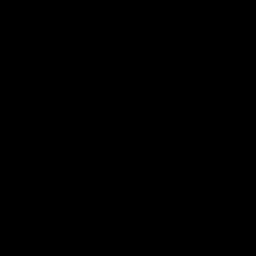

In [0]:
cv2_imshow( b_mask )

In [0]:
b_masks

AttributeError: ignored

In [0]:
np.where( fb_masks[10][1] != 1)
# print( fb_masks[10][1] )
# for i in range(256):
#    print( fb_masks[10][1][i] )

(array([  0,   0,   0, ..., 255, 255, 255]),
 array([  0,   1,   2, ..., 253, 254, 255]))

In [0]:
np.unique(fb_masks[10][1] )

array([  0, 255], dtype=uint8)